In [1]:
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy
import numpy as np
import matplotlib.pyplot as plt
import random as rn


from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
from scipy.ndimage import imread

from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.mobilenet import MobileNet
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

Using TensorFlow backend.


In [2]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [3]:
data_dir = 'data/'
augs_gen = ImageDataGenerator(
    rescale=1./255,        
    horizontal_flip=True,
    height_shift_range=.2,
    vertical_flip = True,
    validation_split = 0.2
)  

train_gen = augs_gen.flow_from_directory(
    data_dir,
    target_size = (224,224),
    batch_size=32,
    class_mode = 'categorical',
    shuffle=True,
)

val_gen = augs_gen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset = 'validation'
)

Found 2188 images belonging to 3 classes.
Found 437 images belonging to 3 classes.


In [4]:
model_base = MobileNet(weights='imagenet',include_top=False,input_shape=(224,224,3))
model = Sequential()
model.add(model_base)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0,5))
model.add(Dense(3,activation='softmax'))
model.summary()


W0709 21:45:58.416339 140547230332672 deprecation_wrapper.py:119] From /home/dragneel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0709 21:45:58.439208 140547230332672 deprecation_wrapper.py:119] From /home/dragneel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0709 21:45:58.448174 140547230332672 deprecation_wrapper.py:119] From /home/dragneel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0709 21:45:58.490322 140547230332672 deprecation_wrapper.py:119] From /home/dragneel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_de

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 3,231,939
Trainable params: 3,210,051
Non-trainable params: 21,888
_________________________________________________________________


In [5]:
best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=40,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [6]:
opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=2e-4)

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
    
history = model.fit_generator(
    train_gen, 
    steps_per_epoch  = 50, 
    validation_data  = val_gen,
    validation_steps = 50,
    epochs = 5, 
    verbose = 1,
    callbacks=callbacks
)

W0709 21:46:08.261398 140547230332672 deprecation_wrapper.py:119] From /home/dragneel/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0709 21:46:08.294628 140547230332672 deprecation.py:323] From /home/dragneel/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0709 21:46:13.868002 140547230332672 deprecation_wrapper.py:119] From /home/dragneel/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0709 21:46:13.868803 140547230332672 deprecation_wrapper.py:119] From /home/dragneel/anaconda3/lib/python3.7/site-packages/keras/cal

Epoch 1/5
50/50 [==============================] - 467s 9s/step - loss: 0.0798 - acc: 0.9771 - val_loss: 0.0820 - val_acc: 0.9785

Epoch 00001: val_loss improved from inf to 0.08200, saving model to ./base.model
Epoch 2/5
50/50 [==============================] - 411s 8s/step - loss: 0.0658 - acc: 0.9862 - val_loss: 0.0381 - val_acc: 0.9927

Epoch 00002: val_loss improved from 0.08200 to 0.03806, saving model to ./base.model
Epoch 3/5
50/50 [==============================] - 414s 8s/step - loss: 0.0116 - acc: 0.9975 - val_loss: 0.0181 - val_acc: 0.9949

Epoch 00003: val_loss improved from 0.03806 to 0.01810, saving model to ./base.model
Epoch 4/5
50/50 [==============================] - 420s 8s/step - loss: 0.0164 - acc: 0.9950 - val_loss: 0.0141 - val_acc: 0.9970

Epoch 00004: val_loss improved from 0.01810 to 0.01413, saving model to ./base.model
Epoch 5/5
50/50 [==============================] - 417s 8s/step - loss: 0.0276 - acc: 0.9949 - val_loss: 0.0323 - val_acc: 0.9940

Epoch 000

Model Test Loss: 0.003247532377192864
Model Test Accuracy: 0.9983818801089783
Weights Saved


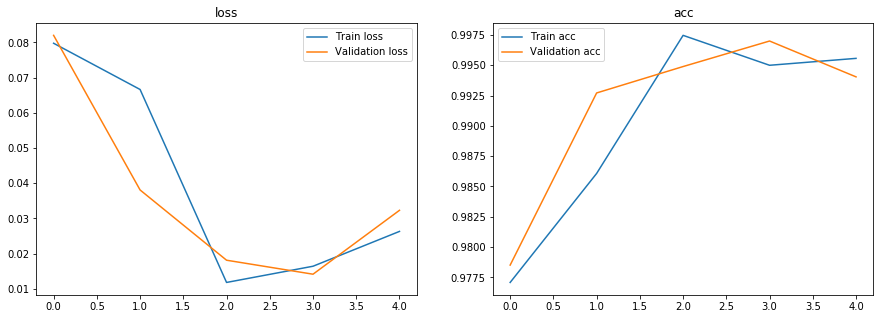

In [7]:
show_final_history(history)
model.load_weights(best_model_weights)
model_score = model.evaluate_generator(val_gen,steps=20)
print("Model Test Loss:",model_score[0])
print("Model Test Accuracy:",model_score[1])

model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
    
model.save("model.h5")
print("Weights Saved")